In [170]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tianhwu/brooklynhomes2003to2017")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Owner\.cache\kagglehub\datasets\tianhwu\brooklynhomes2003to2017\versions\2


In [171]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

import joblib
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')

In [172]:
path = r"C:\Users\Owner\Documents\RStudio\MappingProjects\Models\BrooklynHomes\brooklyn_sales_map.csv"  # Replace 'filename.csv' with the actual file name
df = pd.read_csv(path)
df.head()

C:\Users\Owner\AppData\Local\Temp\ipykernel_23904\1093347166.py:2: DtypeWarning: Columns (39,40,42,44,45,46,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,borough,neighborhood,building_class_category,tax_class,block,lot,easement,building_class,address,apartment_number,...,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
0,3,DOWNTOWN-METROTECH,28 COMMERCIAL CONDOS,4,140,1001,NaN,R5,330 JAY STREET,COURT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,DOWNTOWN-FULTON FERRY,29 COMMERCIAL GARAGES,4,54,1,NaN,G7,85 JAY STREET,NaN,...,NaN,3.000540e+09,12/6/2002,1.0,NaN,NaN,17V1.1,0.0,1559.889144,140131.57720
2,3,BROOKLYN HEIGHTS,21 OFFICE BUILDINGS,4,204,1,NaN,O6,29 COLUMBIA HEIGHTS,NaN,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,890.718521,34656.44724
3,3,MILL BASIN,22 STORE BUILDINGS,4,8470,55,NaN,K6,5120 AVENUE U,NaN,...,NaN,0.000000e+00,NaN,1.0,1.0,1.0,17V1.1,0.0,3729.786857,797554.84780
4,3,BROOKLYN HEIGHTS,26 OTHER HOTELS,4,230,1,NaN,H8,21 CLARK STREET,NaN,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,620.761169,21360.14763


In [173]:
df['sale_price'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])


0.000            0.0
0.250            0.0
0.500       275000.0
0.750       593000.0
0.900       965000.0
0.950      1445000.0
0.990      4075000.0
0.997     10250000.0
1.000    499401179.0
Name: sale_price, dtype: float64

In [174]:
df['year_built'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])

0.000       0.0
0.250    1905.0
0.500    1925.0
0.750    1954.0
0.900    2004.0
0.950    2007.0
0.990    2013.0
0.997    2015.0
1.000    2017.0
Name: year_built, dtype: float64

In [175]:
mask = (df['year_built'] > 1900) & (df['sale_price'] > 100000) & (df['sale_price'] < 1e7)
df = df[mask]

In [176]:
df.shape

(189697, 110)

# FEATURE ENGINEERING



In [177]:
req_cols = []

for col in df.columns:
    is_na = round(df[col].isna().sum() / len(df) * 100, 2)
    if is_na < 50:
        req_cols.append(col)
    print(f"{col} has {is_na} % of nan values")

print(f"{len(req_cols)} has less than 50% of nan values")
df = df[req_cols]
print(df.shape)

borough has 0.0 % of nan values
neighborhood has 0.0 % of nan values
building_class_category has 0.0 % of nan values
tax_class has 0.0 % of nan values
block has 0.0 % of nan values
lot has 0.0 % of nan values
easement has 100.0 % of nan values
building_class has 0.0 % of nan values
address has 0.0 % of nan values
apartment_number has 81.93 % of nan values
zip_code has 0.0 % of nan values
residential_units has 0.0 % of nan values
commercial_units has 0.0 % of nan values
total_units has 0.0 % of nan values
land_sqft has 0.0 % of nan values
gross_sqft has 0.0 % of nan values
year_built has 0.0 % of nan values
tax_class_at_sale has 0.0 % of nan values
building_class_at_sale has 0.0 % of nan values
sale_price has 0.0 % of nan values
sale_date has 0.0 % of nan values
year_of_sale has 0.0 % of nan values
Borough has 16.1 % of nan values
CD has 16.1 % of nan values
CT2010 has 16.11 % of nan values
CB2010 has 16.11 % of nan values
SchoolDist has 16.11 % of nan values
Council has 16.1 % of nan v

In [178]:
cat_cols = df.select_dtypes('object').columns
k = 0
cardinality_cols = []

for col in cat_cols:
    value_counts = df[col].value_counts(normalize=True).round(2)
    if len(value_counts) > 5 or len(value_counts) < 2:
        cardinality_cols.append(col)
    else:
        print("====================================================================")
        print(col)
        print(value_counts)

cardinality_cols.remove('neighborhood')
cardinality_cols.remove('building_class_at_sale')
print(f"Removed Columns: {cardinality_cols}")
df.drop(columns=cardinality_cols, axis=1, inplace=True)

SplitZone
SplitZone
N    0.94
Y    0.06
Name: proportion, dtype: float64
IrrLotCode
IrrLotCode
N    0.8
Y    0.2
Name: proportion, dtype: float64
Removed Columns: ['building_class_category', 'tax_class', 'building_class', 'address', 'sale_date', 'Borough', 'FireComp', 'SanitSub', 'Address', 'ZoneDist1', 'BldgClass', 'OwnerName', 'ZoneMap', 'Sanborn', 'Version']


In [179]:
neighborhood = df['neighborhood'].value_counts(normalize=True).round(2)
idx = np.where(neighborhood > 0.01)[0].max()
places = neighborhood.index[:idx]
df['neighborhood'] =df['neighborhood'].apply(lambda x: x if x in places else 'OTHER')
df['neighborhood'].value_counts(normalize=True)

neighborhood
OTHER                  0.244474
EAST NEW YORK          0.051487
BAY RIDGE              0.047033
BEDFORD STUYVESANT     0.046906
BUSHWICK               0.041767
BOROUGH PARK           0.039289
CANARSIE               0.038656
FLATBUSH-EAST          0.038372
SHEEPSHEAD BAY         0.038008
PARK SLOPE             0.034513
CROWN HEIGHTS          0.033580
GRAVESEND              0.030217
SUNSET PARK            0.027080
FLATBUSH-CENTRAL       0.025778
OCEAN PARKWAY-NORTH    0.025145
BENSONHURST            0.024776
MIDWOOD                0.020591
MARINE PARK            0.019721
OCEAN HILL             0.019394
CYPRESS HILLS          0.019157
MADISON                0.018846
BROOKLYN HEIGHTS       0.017723
OCEAN PARKWAY-SOUTH    0.017064
FLATBUSH-NORTH         0.016816
BRIGHTON BEACH         0.016695
GREENPOINT             0.015662
CLINTON HILL           0.015662
WILLIAMSBURG-EAST      0.015588
Name: proportion, dtype: float64

In [180]:
num_cols = df.select_dtypes('number').columns

low_var_cols = []
for col in num_cols:
    scaled = (df[col] - df[col].mean()) / df[col].std()
    variance = scaled.var().round(4)
    if variance == 0 or df[col].std() == 0:
        low_var_cols.append(col)
#     else:
#         print(col, variance)

df.drop(columns=low_var_cols, axis=1, inplace=True)
print(f"Removed Columns: {low_var_cols}")
print(df.shape, len(low_var_cols))

Removed Columns: ['borough', 'BoroCode']
(189697, 73) 2


In [181]:
df['age'] = 2023 - (df['year_built'] + df['YearBuilt']) // 2
df.drop(['zip_code', 'ZipCode', 'year_built', 'YearBuilt', 'year_of_sale'], axis=1, inplace=True)



In [ ]:
df.head(100)
# Cartesian coordinates used

,neighborhood,block,lot,residential_units,commercial_units,total_units,land_sqft,gross_sqft,tax_class_at_sale,building_class_at_sale,...,Tract2010,XCoord,YCoord,TaxMap,APPBBL,PLUTOMapID,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,age
1069,OTHER,155,14,0,1,1,9679.0,25480.0,4,K4,...,37.0,987900.0,191021.0,30104.0,0.0,1.0,0.0,420.648004,11025.971440,74.0
1071,OTHER,1033,5,0,1,1,2454.0,24771.0,4,H3,...,117.0,986195.0,182884.0,30404.0,0.0,1.0,0.0,249.749693,2486.748396,14.0
1072,BEDFORD STUYVESANT,1985,14,44,1,45,20000.0,43520.0,4,N2,...,229.0,995793.0,188823.0,30703.0,0.0,1.0,0.0,600.614280,19929.413360,93.0
1073,OCEAN HILL,1455,70,0,2,2,16352.0,31611.0,4,K4,...,36502.0,1009228.0,184586.0,30508.0,0.0,1.0,0.0,799.444342,32144.801000,8.0
1074,FLATBUSH-EAST,4891,6,63,0,63,12792.0,46680.0,2,D1,...,858.0,1000303.0,176411.0,31508.0,0.0,1.0,0.0,462.102461,13150.131540,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,FLATBUSH-CENTRAL,5123,25,66,0,66,21225.0,81312.0,2,D1,...,51001.0,995179.0,174542.0,31603.0,0.0,1.0,0.0,599.725677,22478.753440,99.0
1177,MADISON,6794,74,0,1,1,8000.0,11200.0,4,K1,...,554.0,994947.0,160317.0,32009.0,0.0,1.0,0.0,363.584090,8151.987134,63.0
1178,BROOKLYN HEIGHTS,226,4,48,0,48,5000.0,21000.0,2,D3,...,1.0,985944.0,193864.0,30106.0,0.0,1.0,0.0,306.548701,5173.512179,83.0
1179,CANARSIE,8235,342,0,2,2,77600.0,33350.0,4,I7,...,1018.0,1014371.0,175540.0,32406.0,0.0,1.0,0.0,1146.332612,70674.897590,62.0


In [183]:
# check for multicollinearity
numeric_df = df.select_dtypes(include=[np.number])  
corr = numeric_df.drop('sale_price', axis=1).corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
print(f"Columns dropped are: {drop}")
df.drop(columns=drop, axis=1, inplace=True)

Columns dropped are: ['total_units', 'CD', 'Council', 'PolicePrct', 'HealthArea', 'SanitDistr', 'BldgArea', 'ResArea', 'GarageArea', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot', 'BuiltFAR', 'FacilFAR', 'BBL', 'YCoord', 'TaxMap', 'SHAPE_Leng', 'SHAPE_Area', 'age']


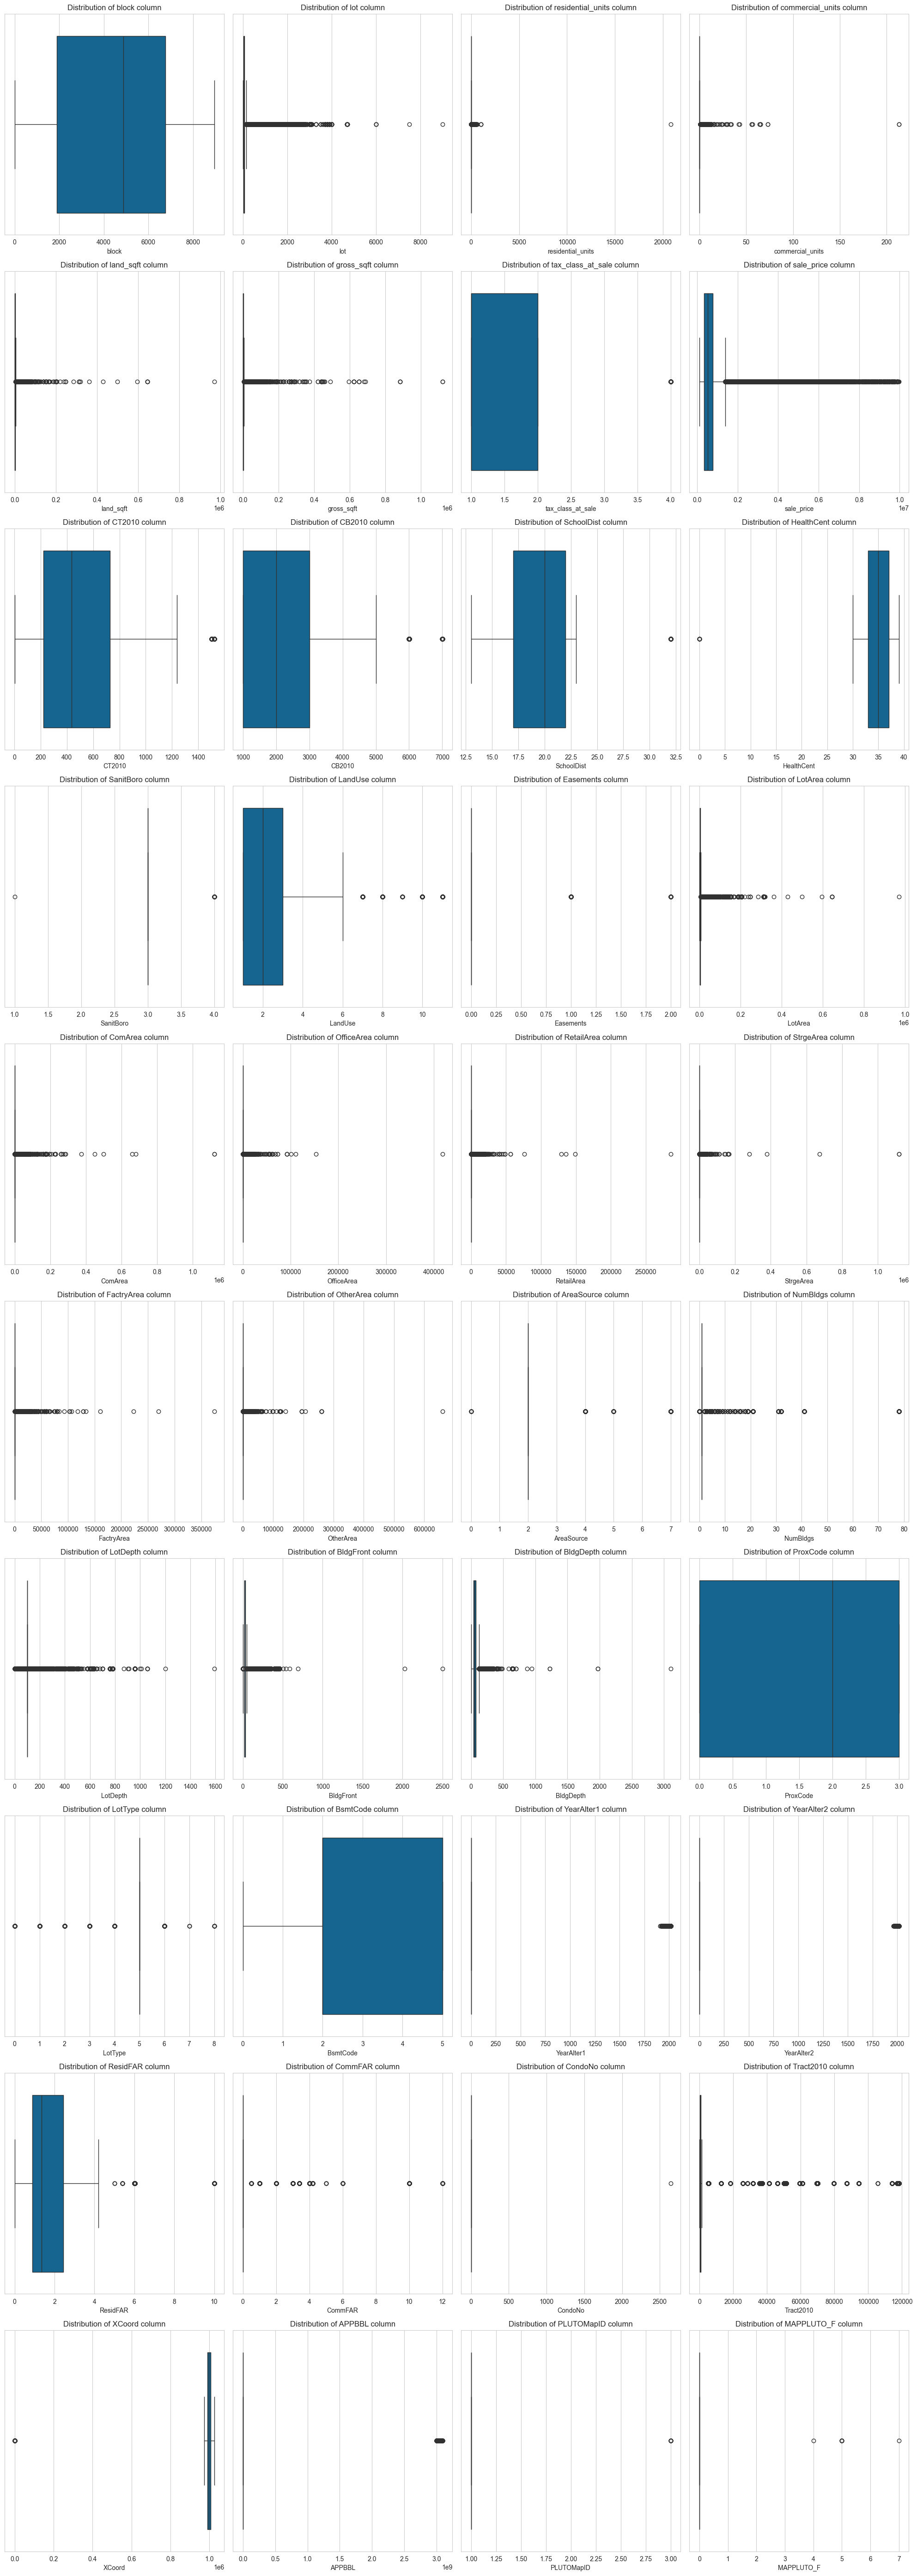

In [184]:
num_cols = df.select_dtypes('number').columns
k = 0
plt.figure(figsize=(20, 100))
for col in num_cols:
    plt.subplot(18, 4, k + 1)
    sns.boxplot(data=df, x=col)
    plt.xlabel(col)
    plt.title(f"Distribution of {col} column")
    k += 1
plt.tight_layout()

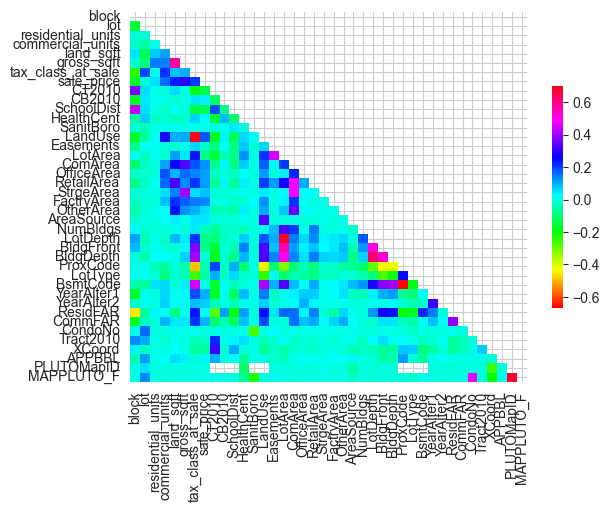

<Figure size 1600x1200 with 0 Axes>

In [185]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='hsv', annot=False, fmt=".2f",  xticklabels=corr.columns,  # Explicitly label x-axis
    yticklabels=corr.columns,  cbar_kws={"shrink": 0.6}   # Explicitly label y-axis
)
plt.figure(figsize=(16, 12))
# Display the plot
plt.show()

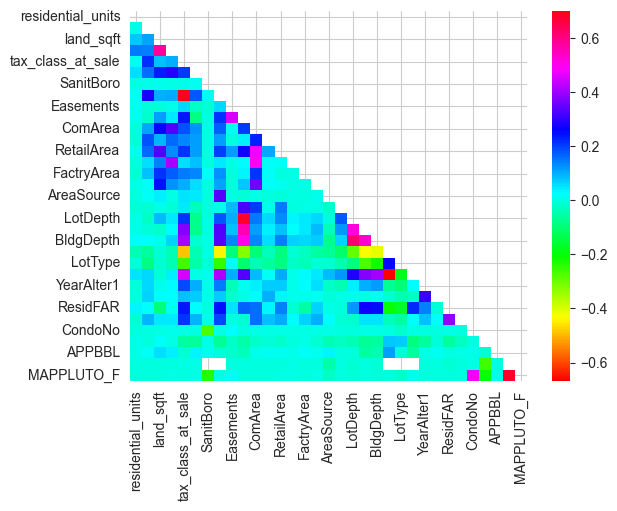

<Figure size 1600x1200 with 0 Axes>

In [193]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='hsv', annot=False, fmt=".2f"   # Explicitly label y-axis
)
plt.figure(figsize=(16, 12))
# Display the plot
plt.show()

In [186]:
drop_cols = ['block', 'lot', 'CT2010', 'CB2010', 'HealthCent', 'SchoolDist', 'Tract2010']
df.drop(columns=drop_cols, axis=1, inplace=True)

In [187]:
brooklyn = df.copy()

In [188]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189697 entries, 1069 to 390879
Data columns (total 37 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neighborhood            189697 non-null  object 
 1   residential_units       189697 non-null  int64  
 2   commercial_units        189697 non-null  int64  
 3   land_sqft               189697 non-null  float64
 4   gross_sqft              189697 non-null  float64
 5   tax_class_at_sale       189697 non-null  int64  
 6   building_class_at_sale  189697 non-null  object 
 7   sale_price              189697 non-null  float64
 8   SanitBoro               159140 non-null  float64
 9   SplitZone               159145 non-null  object 
 10  LandUse                 159072 non-null  float64
 11  Easements               159154 non-null  float64
 12  LotArea                 159154 non-null  float64
 13  ComArea                 159154 non-null  float64
 14  OfficeArea            

In [189]:
viz_df = brooklyn.copy()
median_home_price = viz_df['sale_price'].median().round(2)
median_home_price

510000.0

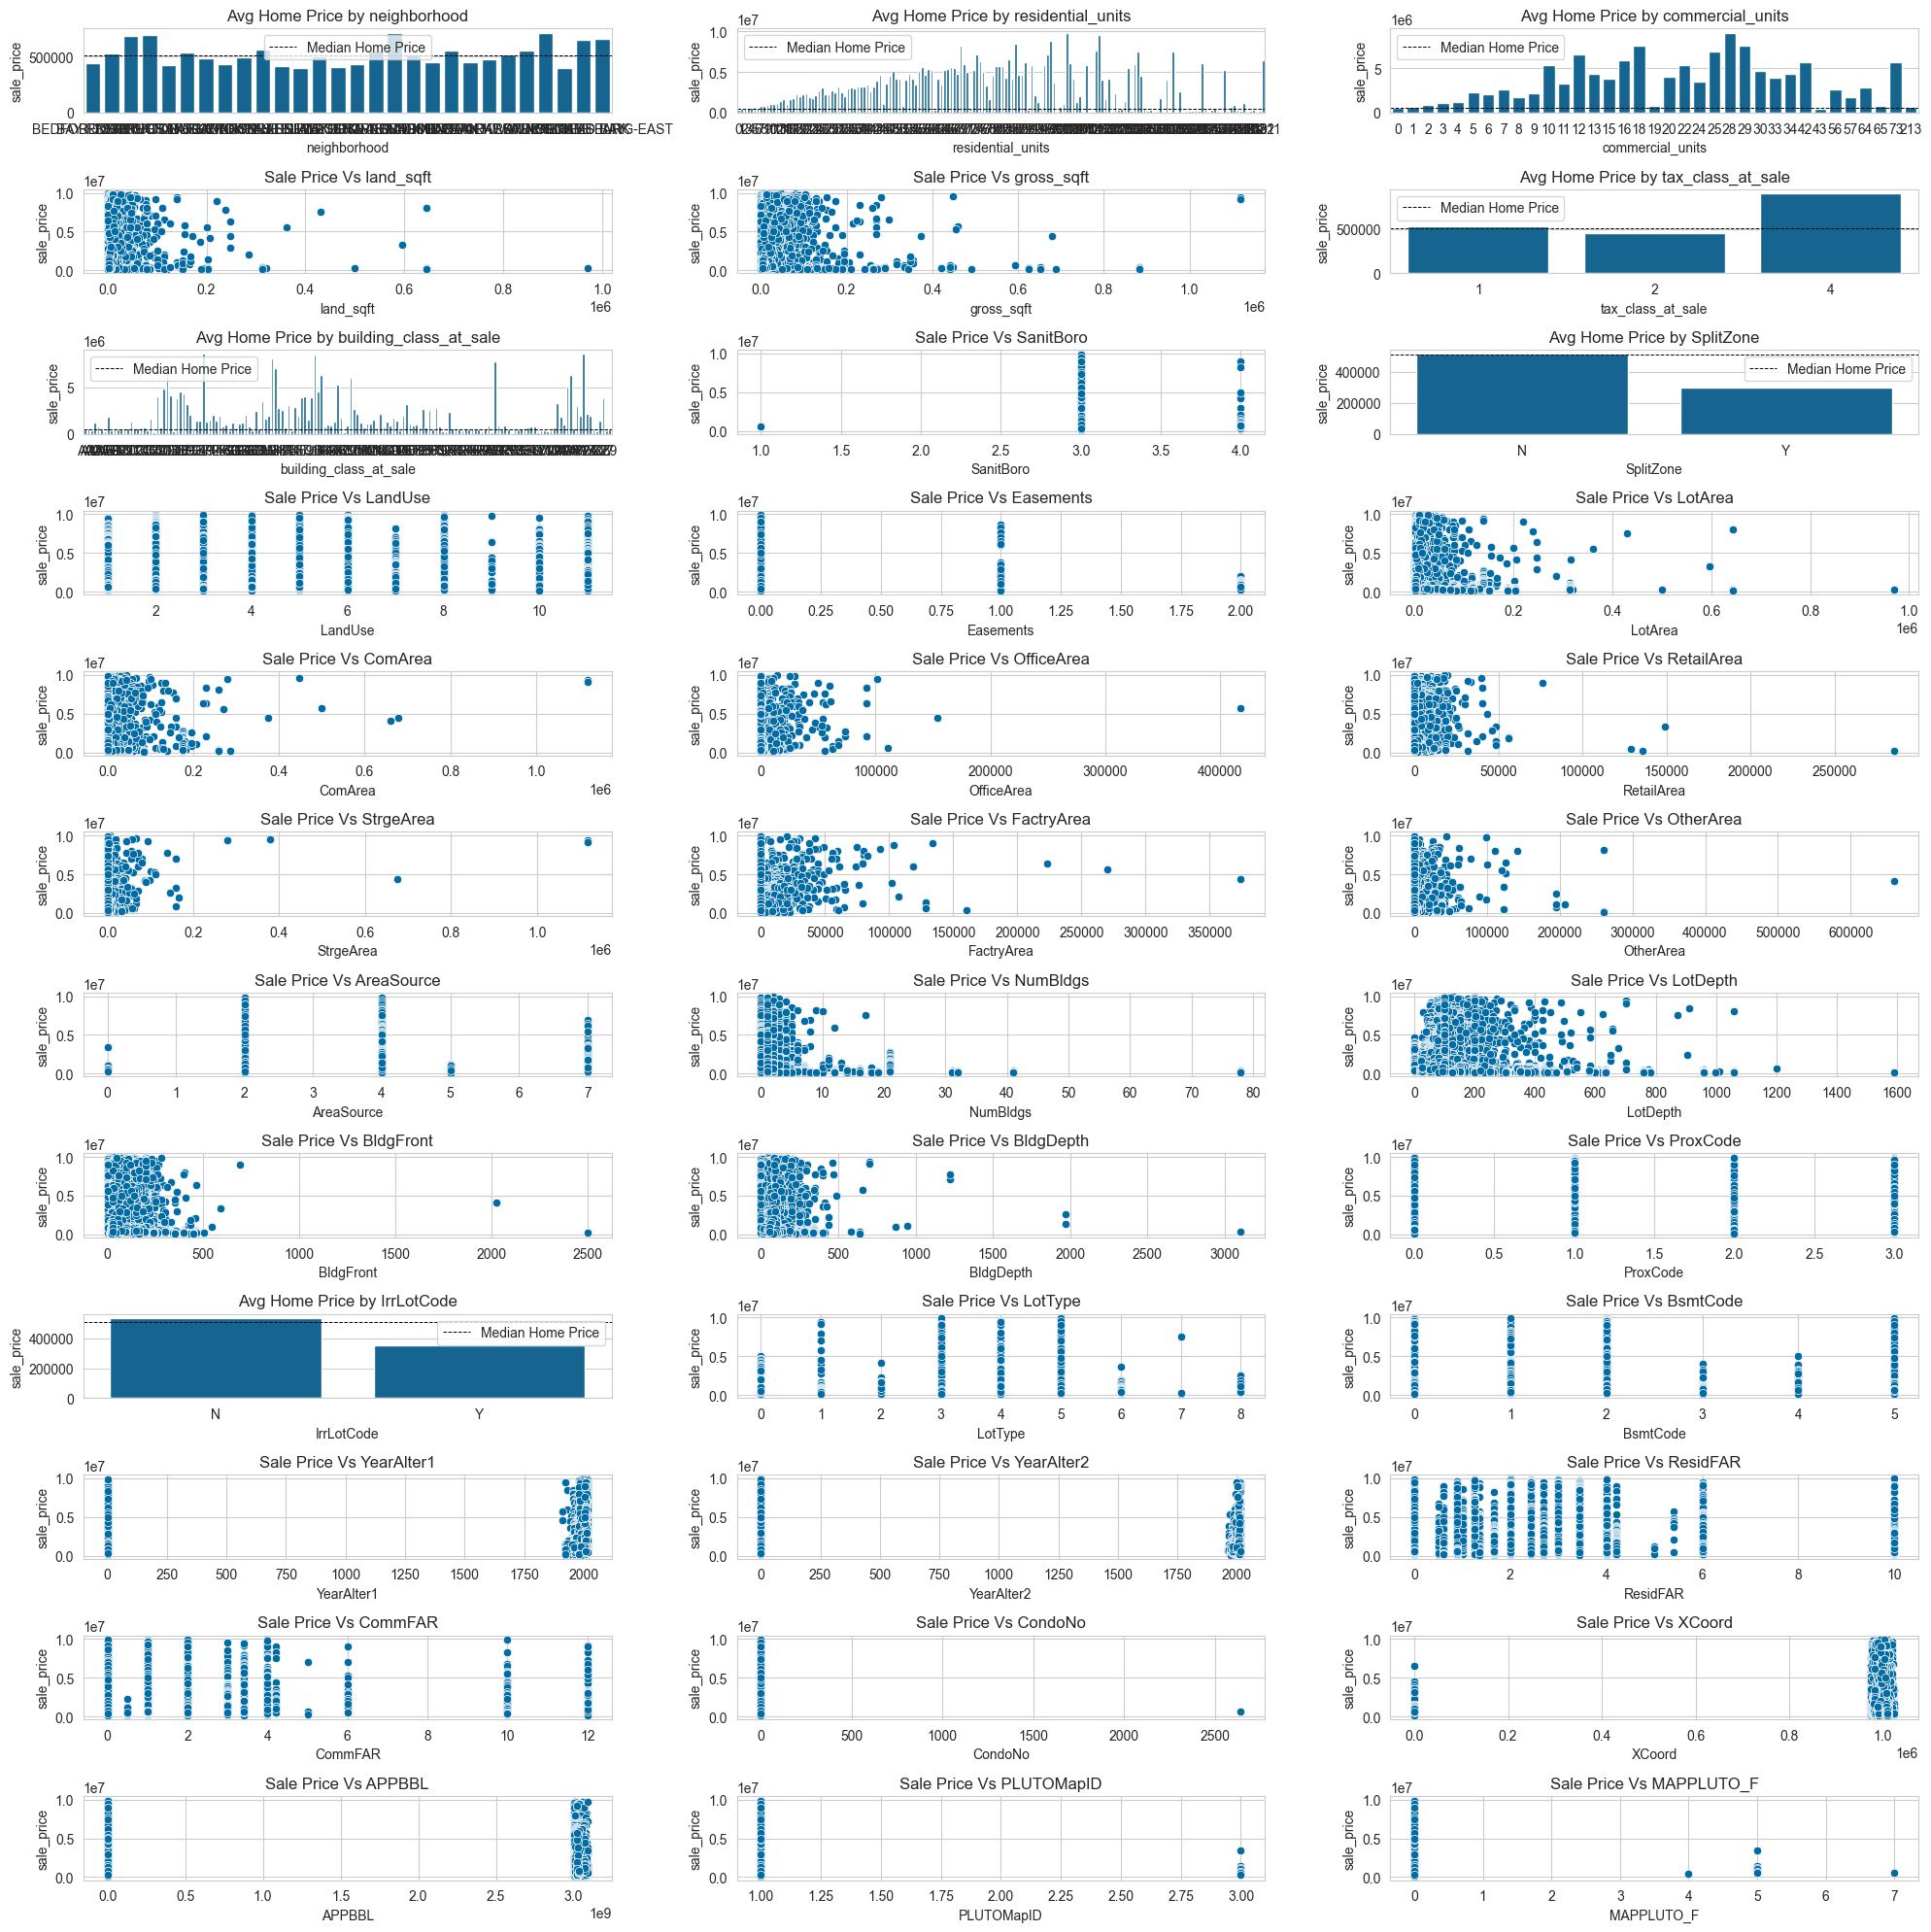

In [195]:
k = 0
plt.figure(figsize=(20, 20))

# Determine the number of columns to plot
columns_to_plot = viz_df.drop('sale_price', axis=1).columns

# Adjust the number of rows and columns in the grid dynamically
rows = (len(columns_to_plot) + 2) // 3  # +2 ensures rounding up for incomplete rows
cols = 3  # Fixed number of columns

for col in columns_to_plot:
    plt.subplot(rows, cols, k + 1)  # Dynamically adjust grid based on rows and cols
    if viz_df[col].dtype == 'float64':
        sns.scatterplot(data=viz_df, x=col, y='sale_price')
        plt.title(f"Sale Price Vs {col}")
    else:
        group = viz_df[[col, 'sale_price']].groupby(by=col).median()
        sns.barplot(data=group, x=group.index, y='sale_price')
        plt.axhline(y=median_home_price, label='Median Home Price', color='black', linestyle='--', linewidth=0.7)
        plt.title(f"Avg Home Price by {col}")
        plt.legend()
    k += 1

plt.tight_layout()
plt.show()

<Axes: xlabel='sale_price', ylabel='Count'>

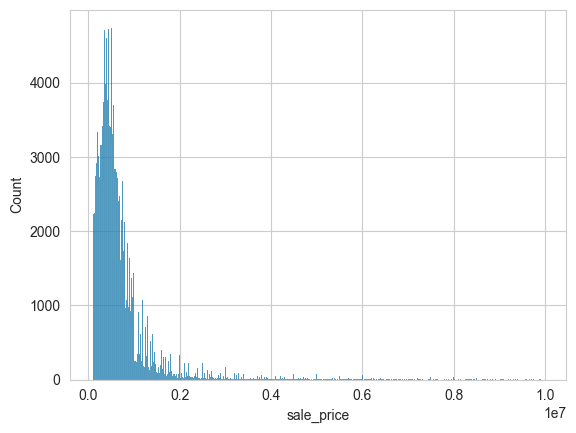

In [196]:
sns.histplot(viz_df['sale_price'])

<Axes: xlabel='sale_price', ylabel='Count'>

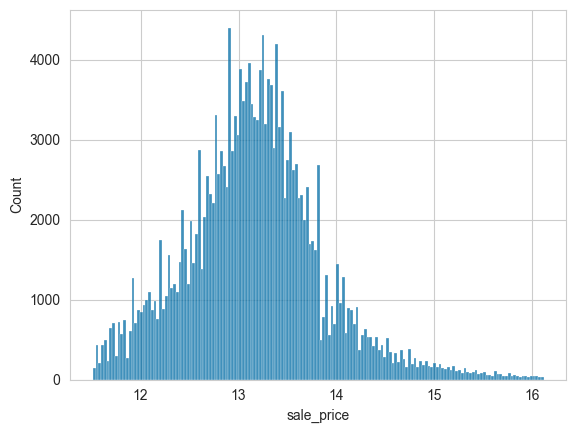

In [197]:
sns.histplot(np.log(viz_df['sale_price']))

# MACHINE LEARNING MODELS

In [198]:
X_train, X_test, y_train, y_test = train_test_split(brooklyn.drop('sale_price', axis=1), brooklyn['sale_price'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((151757, 36), (37940, 36), (151757,), (37940,))

In [202]:
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

y_mean = brooklyn['sale_price'].mean().round(2)
print("Baseline R2 Score:", r2_score(y_test, [y_mean] * len(y_test)).round(2))
print("Baseline Root Mean Squared Error:", root_mean_squared_error(y_test, [y_mean] * len(y_test)).round(2))

Baseline R2 Score: -0.0
Baseline Root Mean Squared Error: 794879.7


## Base

In [203]:
def train_model(model):
    model.fit(X_train, np.log(y_train))
    print(f"Train R-Squared: {r2_score(y_train, np.exp(model.predict(X_train))).round(2)}")
    print(f"Test R-Squared: {r2_score(y_test, np.exp(model.predict(X_test))).round(2)}")
    print(f"Train Root Mean Squared Error: {mean_squared_error(y_train, np.exp(model.predict(X_train)), squared=False).round(2)}")
    print(f"Test Root Mean Squared Error: {mean_squared_error(y_test, np.exp(model.predict(X_test)), squared=False).round(2)}")
    return model

## Random Forest Regressor

In [204]:
rf = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)
rf = train_model(rf)

Train R-Squared: 0.78
Test R-Squared: 0.47


c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train Root Mean Squared Error: 363678.18
Test Root Mean Squared Error: 577648.57


c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [205]:
# Hyperparameter Tuning using Randomized SearchCV
params = {
    'randomforestregressor__n_estimators': np.arange(25, 126, 25),
    'randomforestregressor__min_samples_split': np.arange(2, 26, 5)
}
rf_grid = RandomizedSearchCV(
    estimator = rf,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_grid = train_model(rf_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train R-Squared: 0.64
Test R-Squared: 0.48
Train Root Mean Squared Error: 462553.08
Test Root Mean Squared Error: 572849.1


c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [206]:
rf_grid.best_estimator_

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['neighborhood', 'building_class_at_sale',
                                     'SplitZone', 'IrrLotCode'])),
                ('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_split=22, n_jobs=-1,
                                       random_state=42))])

## XGBoost Regressor

In [207]:
xgb = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    XGBRegressor(random_state=42, n_jobs=-1),
)
xgb = train_model(xgb)

Train R-Squared: 0.6
Test R-Squared: 0.49
Train Root Mean Squared Error: 489062.05
Test Root Mean Squared Error: 569038.29


c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Categorical Boost Regressor

In [240]:
categorical_columns = X_train.select_dtypes('object').columns
X_train[categorical_columns] = X_train[categorical_columns].fillna('missing')
X_test[categorical_columns] = X_test[categorical_columns].fillna('missing')

# Train CatBoostRegressor
cat = CatBoostRegressor(
    cat_features=list(categorical_columns),
    verbose=0
)
cat.fit(X_train, np.log(y_train))
cat = train_model(cat)

Train R-Squared: 0.56
Test R-Squared: 0.49
Train Root Mean Squared Error: 514404.91
Test Root Mean Squared Error: 565834.8


c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model Inferences

In [212]:
joblib.dump(rf_grid, 'randomforest.pkl', compress=9)
joblib.dump(xgb, 'xgboost.pkl', compress=9)
joblib.dump(cat, 'catboost.pkl', compress=9)

['catboost.pkl']

In [229]:
with open('xgboost.pkl', 'rb') as f:
    xgb_pipeline = joblib.load(f)

print("Pipeline Steps:", xgb_pipeline.named_steps)

Pipeline Steps: {'targetencoder': TargetEncoder(cols=['neighborhood', 'building_class_at_sale', 'SplitZone',
                    'IrrLotCode']), 'robustscaler': RobustScaler(), 'xgbregressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)}


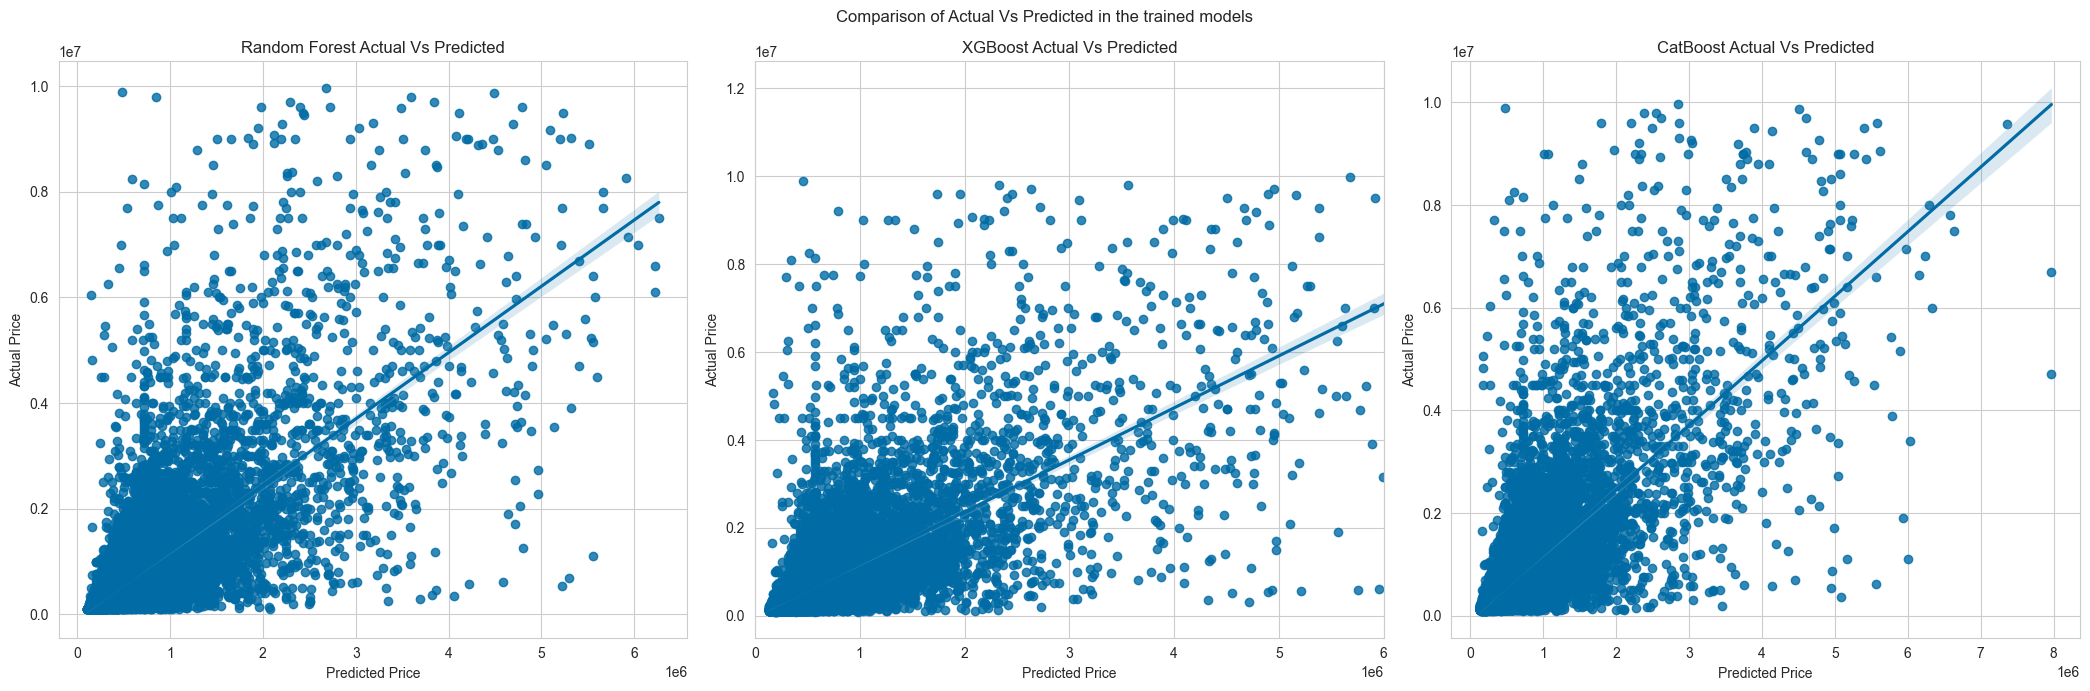

In [241]:
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
preds = np.exp(rf_grid.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Actual Vs Predicted');

plt.subplot(1, 3, 2)
preds = np.exp(xgb.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlim(0, 6e6)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Actual Vs Predicted');

plt.subplot(1, 3, 3)
preds = np.exp(cat.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('CatBoost Actual Vs Predicted');

plt.suptitle('Comparison of Actual Vs Predicted in the trained models')
plt.tight_layout()

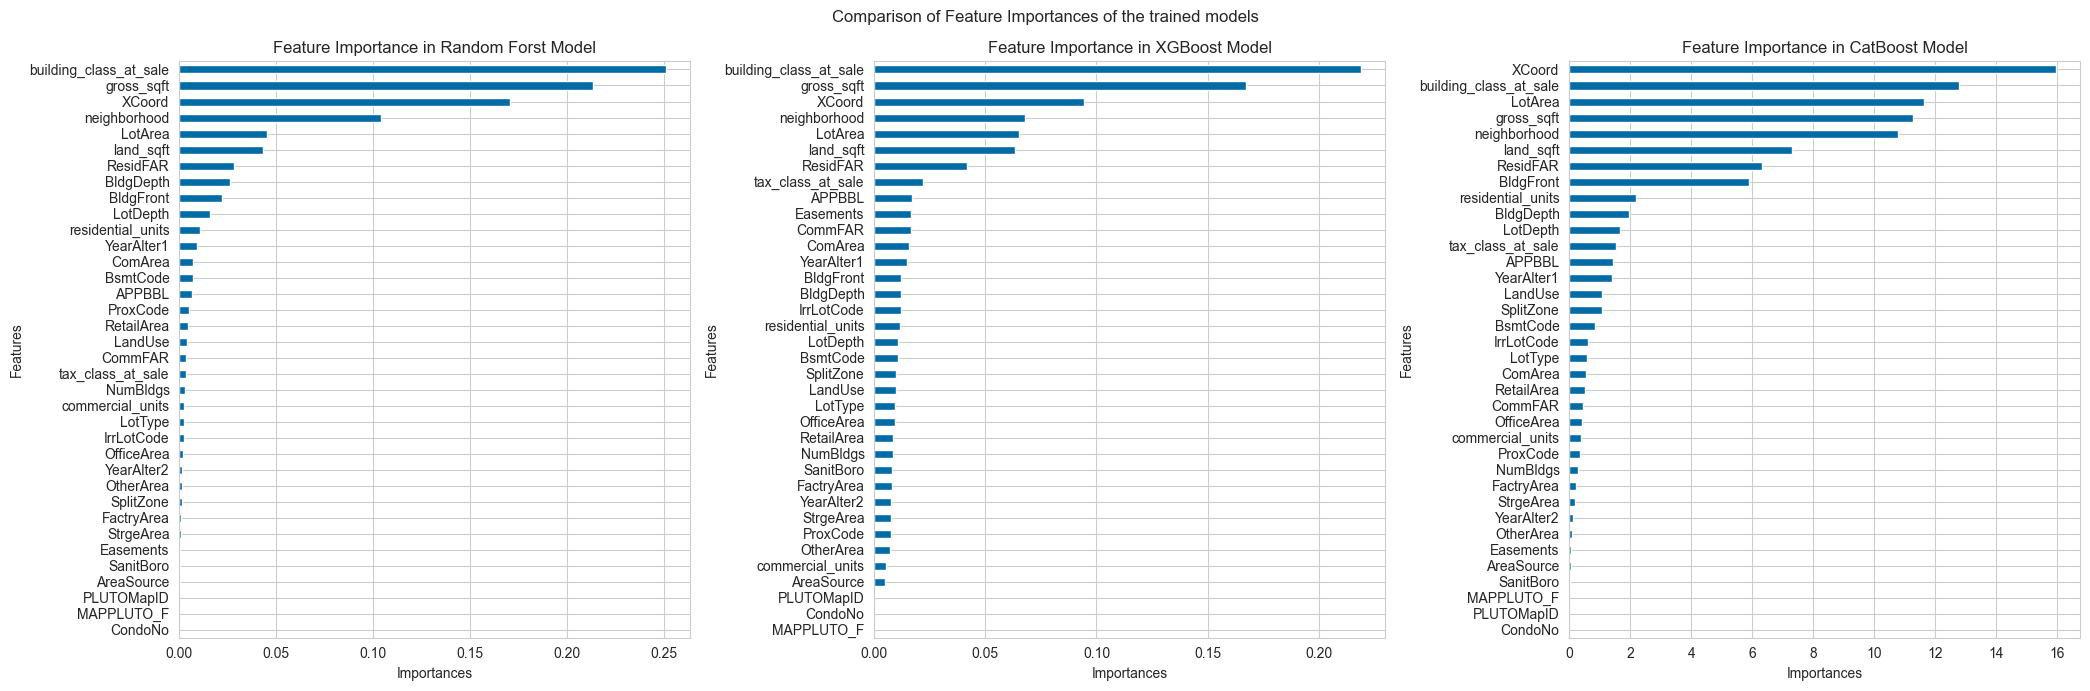

In [242]:
plt.figure(figsize=(21, 7))
feat_imp = rf_grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_
rf_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 1)
rf_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forst Model');

feat_imp = xgb.named_steps['xgbregressor'].feature_importances_
xgb_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 2)
xgb_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost Model');

feat_imp = cat.get_feature_importance()
cat_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 3)
cat_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost Model')

plt.suptitle('Comparison of Feature Importances of the trained models')
plt.tight_layout();

In [234]:
def predict_house_price(neighborhood, residential_units, land_sqft, tax_class_at_sale,
                        building_class_at_sale, SplitZone, LotArea, LotDepth,
                        ProxCode, IrrLotCode, BsmtCode, ResidFAR, age):
    # User-provided input
    input_data = {
        'neighborhood': neighborhood,
        'residential_units': residential_units,
        'land_sqft': land_sqft,
        'tax_class_at_sale': tax_class_at_sale,
        'building_class_at_sale': building_class_at_sale,
        'SplitZone': SplitZone,
        'LotArea': LotArea,
        'LotDepth': LotDepth,
        'ProxCode': ProxCode,
        'IrrLotCode': IrrLotCode,
        'BsmtCode': BsmtCode,
        'ResidFAR': ResidFAR,
        'age': age
    }

    # Load the trained model pipeline
    with open('xgboost.pkl', 'rb') as f:
        xgb_pipeline = joblib.load(f)
    
    # Use the correct step name
    xgb_model = xgb_pipeline.named_steps['regressor']  # Replace 'regressor' with your actual step name
    
    # Retrieve the model's expected feature names
    expected_features = xgb_model.feature_names_in_
    
    # Create a DataFrame with all expected features
    input_df = pd.DataFrame(columns=expected_features)
    input_df.loc[0] = [input_data.get(col, 0) for col in expected_features]  # Fill missing features with default value (0)
    
    # Predict using the pipeline
    xgb_pred = xgb_pipeline.predict(input_df)
    
    # Transform prediction (if necessary)
    avg = (np.exp(xgb_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"


In [235]:
predicted_price = predict_house_price(
    neighborhood="BROOKLYN HEIGHTS", 
    residential_units=5,              
    land_sqft=4000,                   
    tax_class_at_sale=2,              
    building_class_at_sale="A",       
    SplitZone="N",                    
    LotArea=2000,                     
    LotDepth=50,                      
    ProxCode=1,                       
    IrrLotCode="N",                   
    BsmtCode=3,                       
    ResidFAR=2.5,                     
    age=50                            
)

print(predicted_price)


KeyError: 'regressor'